In [1]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange, tqdm

from collections import defaultdict
from itertools import combinations

In [90]:
# # Read DBLP
edges = pd.read_csv("com-dblp.ungraph.txt", sep='\t', comment="#")
coms = []
with open("com-dblp.all.cmty.txt", "r") as infile:
    for line in infile:
        x = line[:-1]  # drop trailing newline
        x = x.split('\t')
        coms.append(frozenset([int(y) for y in x])) ## map to 0-based

g = ig.Graph.DataFrame(edges, directed=False)

c = [set() for _ in range(g.vcount())]
for i, com in enumerate(coms):
    for v in com:
        c[v].add(i)
        #print(f"Vertex {v} in community {i}")
        #print(f"Vetrex {v} is now in {len(c[v])} coms")
c = [frozenset(i) for i in c] 
g.vs["comms"] = c

g = g.subgraph(np.arange(g.vcount())[np.array(g.degree()) > 0])  # Vertex list is not continugous, degree 0 vertices get added


print(f"{g.vcount()} vertices")
print(f"{g.ecount()} edges")
print(f"{len(coms)} communities")

# Dropping some vars to free up memory
del edges


317080 vertices
1049865 edges
13477 communities


Min size: 6
Max size: 7556
Mean: 53.410996512576986


Text(0, 0.5, 'Frequency')

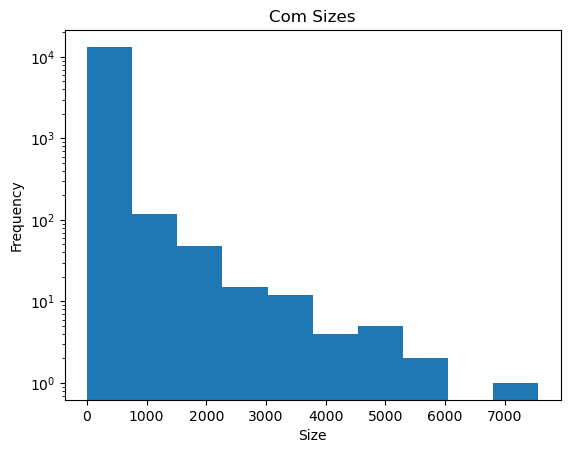

In [91]:
com_sizes = np.array([len(com) for com in coms])

print(f"Min size: {np.min(com_sizes)}")
print(f"Max size: {np.max(com_sizes)}")
print(f"Mean: {np.mean(com_sizes)}")

plt.hist(com_sizes, log=True)
plt.title("Com Sizes")
plt.xlabel("Size")
plt.ylabel("Frequency")

Mean: 2.2701526428661536
Mean for non-zero: 2.7579521682158483
Median: 1.0
Median for non-zero: 1.0
Max: 124
# no coms: 56082
% no coms: 0.17687019048820488


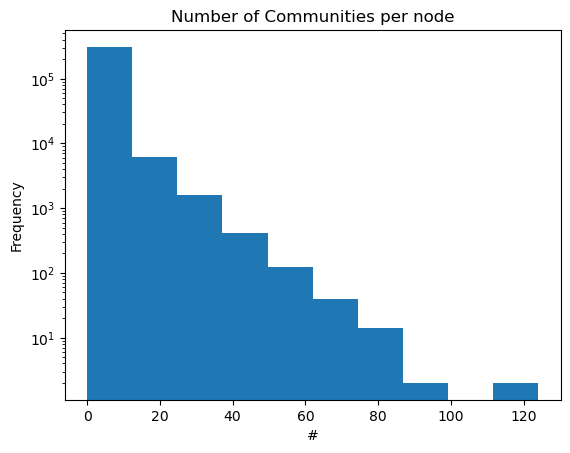

In [92]:
lens = np.array([len(i) for i in g.vs["comms"]])
plt.hist(lens, log=True)
plt.title("Number of Communities per node")
plt.xlabel("#")
plt.ylabel("Frequency")

print(f"Mean: {np.mean(lens)}")
print(f"Mean for non-zero: {np.mean(lens[lens>0])}")
print(f"Median: {np.median(lens)}")
print(f"Median for non-zero: {np.median(lens[lens>0])}")
print(f"Max: {np.max(lens)}")
print(f"# no coms: {np.sum(lens == 0)}")
print(f"% no coms: {np.sum(lens == 0) / len(lens)}")

In [93]:
two_overlaps = defaultdict(int)
three_overlaps = defaultdict(int)
four_overlaps = defaultdict(int)

skipped = 0
for com in tqdm(g.vs["comms"]):
    if len(com) > 160:
        #print(f"Skipping node with {len(com)} communities")
        skipped += 1
        continue

    for k2 in combinations(com, 2):
        two_overlaps[tuple(sorted(k2))] += 1
    for k3 in combinations(com, 3):
        three_overlaps[tuple(sorted(k3))] += 1
    for k4 in combinations(com, 4):
        four_overlaps[tuple(sorted(k4))] += 1


100%|██████████| 317080/317080 [04:46<00:00, 1105.95it/s]  


In [94]:
print(f"Found {len(two_overlaps)} pairs of communities that overlap.")
print(f"Found {len(three_overlaps)} triples of communities that overlap.")
print(f"Found {len(four_overlaps)} quadruples of communities that overlap.")

print(f"Skipped {skipped} nodes.")

Found 598918 pairs of communities that overlap.
Found 12696212 triples of communities that overlap.
Found 179092124 quadruples of communities that overlap.
Skipped 0 nodes.


Bins: [   1    2    5   12   29   69  161  376  877 2048]
{'2 Communities': array([303371, 184090,  65724,  28116,  11873,   4279,   1230,    215,
           20]), '3 Communities': array([9180256, 2758542,  566754,  148226,   34598,    6757,     972,
           107,       0]), '4 Communities': array([154359758,  21920609,   2355674,    387282,     59992,      8116,
             687,         6,         0])}


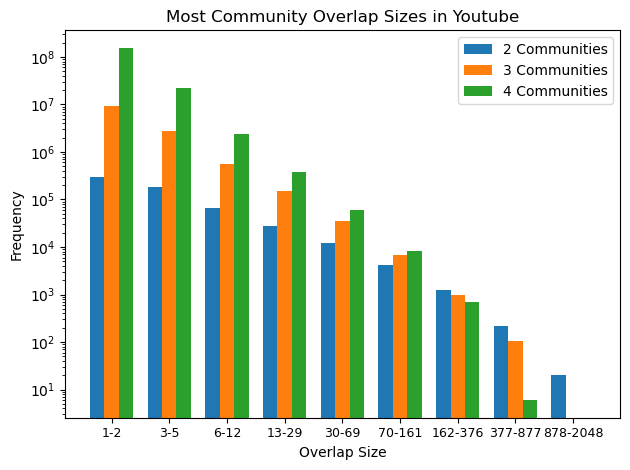

In [95]:
bins = np.logspace(0, 11, num=10, base=2, dtype="int64")
#bins = np.linspace(0, 700, num=10)
print(f"Bins: {bins}")

two_counts = np.histogram(list(two_overlaps.values()), bins=bins)[0]
three_counts = np.histogram(list(three_overlaps.values()), bins=bins)[0]
four_counts = np.histogram(list(four_overlaps.values()), bins=bins)[0]

bin_counts = {
    "2 Communities": two_counts,
    "3 Communities": three_counts,
    "4 Communities": four_counts
}
print(bin_counts)

x = np.arange(len(bins)-1)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

bin_labels = [str(bins[i]+1)+"-"+str(bins[i+1]) for i in range(len(bins)-1)]
bin_labels[0] = "1-2"
bin_labels

fig, ax = plt.subplots()
#plt.grid()

for n_comms, count in bin_counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, count, width, label=n_comms)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_xlabel("Overlap Size")
ax.set_title('Most Community Overlap Sizes in Youtube')
ax.set_yscale('log')
ax.set_xticks(x + width, bin_labels, fontsize=9)
ax.legend()
#ax.set_ylim(0, 250)

plt.tight_layout()
plt.savefig("dblp-overlaps.png")
plt.show()


In [108]:
## Estimate Powerlaw of each 
import powerlaw

## estimates for l' (xmin) and the exponent
print("Two Overlaps:")
vals = list(two_overlaps.values())
X = powerlaw.Fit(vals, discrete=True)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)
print("\n\n")

print("Three Overlaps:")
vals = list(three_overlaps.values())
X = powerlaw.Fit(vals, discrete=True)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)
print("\n\n")

print("Four Overlaps:")
vals = list(four_overlaps.values())
X = powerlaw.Fit(vals, discrete=True)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)

Two Overlaps
Calculating best minimal value for power law fit
xmin progress: 99%
Exponent: 1.9744700374313444
l': 3.0
KS statistic: 0.01097261052268339
Compared to Exponential 86.42933375353053 0.0


Assuming nested distributions


Compared to Truncated -36.52859701064721 0.0
----------------


Three Overlaps
Calculating best minimal value for power law fit
xmin progress: 99%
Exponent: 2.4614300488133063
l': 4.0
KS statistic: 0.007952453895460287
Compared to Exponential 142.35167490822485 0.0


Assuming nested distributions


Compared to Truncated -47.70249635392007 0.0
----------------


Four Overlaps
Calculating best minimal value for power law fit
xmin progress: 99%
Exponent: 2.9552897309240973
l': 6.0
KS statistic: 0.004485940493009877
Compared to Exponential 170.60713696042797 0.0


Assuming nested distributions


Compared to Truncated -39.568549478277525 0.0
----------------




# Repeat with ABCDoo

In [37]:
path = '../../ABCDGraphGenerator.jl/'
#path = 'example/'
#path = '../Datasets/ABCDoo/'
def readGraph():
    ## read edges, build graph
    fn = path+'edge.dat'
    Edges = pd.read_csv(fn, sep='\t', header=None)-1
    G = ig.Graph.DataFrame(Edges, directed=False)
    ## read communities
    fn = path+'com.dat'
    L = []
    with open(fn, "r") as infile:
        for line in infile:
            x = line.split('\t')
            L.append([int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]) ## map to 0-based
    G.vs['comms'] = L
    G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
    return G

g = readGraph()
print(f"{g.vcount()} vertices")
print(f"{g.ecount()} edges")

100000 vertices
643207 edges


Min size: 0
Max size: 9543
Mean: 185.7094133697135


Text(0, 0.5, 'Frequency')

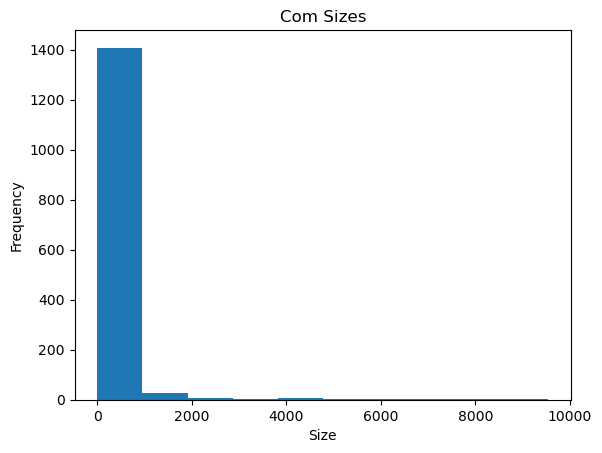

In [38]:
coms = defaultdict(set)
for i, com in enumerate(g.vs["comms"]):
    for c in com:
        coms[c].add(i)
coms[0] = set()
coms = list(coms.values())

com_sizes = np.array([len(com) for com in coms])[:-1]

print(f"Min size: {np.min(com_sizes)}")
print(f"Max size: {np.max(com_sizes)}")
print(f"Mean: {np.mean(com_sizes)}")

plt.hist(com_sizes)
#plt.xscale("log")
#plt.yscale("log")
plt.title("Com Sizes")
plt.xlabel("Size")
plt.ylabel("Frequency")

Mean: 2.73256
Mean for non-zero: 2.73256
Median: 3.0
Median for non-zero: 3.0
Max: 8
# no coms: 0
% no coms: 0.0


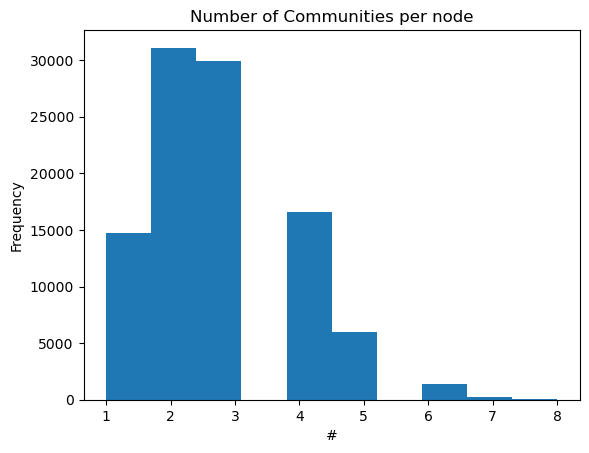

In [39]:
lens = [len(i) for i in g.vs["comms"]]
plt.hist(lens)
plt.title("Number of Communities per node")
plt.xlabel("#")
plt.ylabel("Frequency")

print(f"Mean: {np.mean(lens)}")
print(f"Mean for non-zero: {np.mean(np.array(lens)[np.array(lens)>0])}")
print(f"Median: {np.median(lens)}")
print(f"Median for non-zero: {np.median(np.array(lens)[np.array(lens)>0])}")
print(f"Max: {np.max(lens)}")
print(f"# no coms: {np.sum(np.array(lens) == 0)}")
print(f"% no coms: {np.sum(np.array(lens) == 0) / len(lens)}")

In [40]:
two_overlaps = defaultdict(int)
three_overlaps = defaultdict(int)
four_overlaps = defaultdict(int)

skipped = 0
for com in tqdm(g.vs["comms"]):
    if len(com) > 150:
        print(f"Skipping node with {len(com)} communities")
        skipped += 1
        continue

    for k2 in combinations(com, 2):
        two_overlaps[frozenset(k2)] += 1
    for k3 in combinations(com, 3):
        three_overlaps[frozenset(k3)] += 1
    for k4 in combinations(com, 4):
        four_overlaps[frozenset(k4)] += 1


100%|██████████| 100000/100000 [00:00<00:00, 397539.87it/s]


In [41]:
np.max(list(two_overlaps.values()))

2655

Bins: [   1    2    5   12   29   69  161  376  877 2048]
{'2 Communities': array([1593, 2264, 2258, 1338,  796,  407,  259,  105,   41]), '3 Communities': array([5557, 5651, 3322, 1826,  870,  426,  113,   19,    0]), '4 Communities': array([6991, 5183, 2300, 1050,  364,   60,    4,    0,    0])}


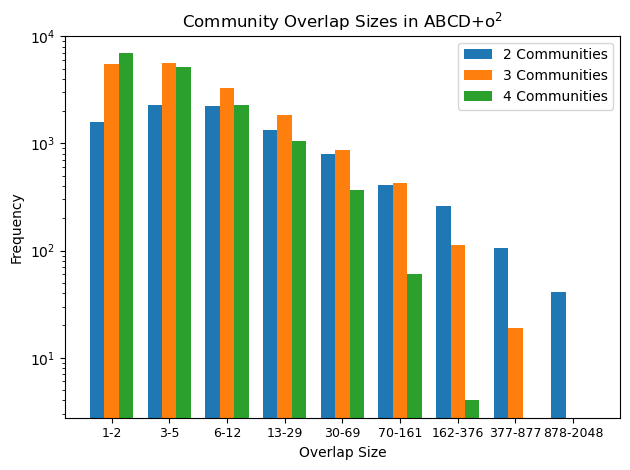

In [42]:
bins = np.logspace(0, 11, num=10, base=2, dtype="int64")
#bins = np.linspace(0, 700, num=10)
print(f"Bins: {bins}")

two_counts = np.histogram(list(two_overlaps.values()), bins=bins)[0]
three_counts = np.histogram(list(three_overlaps.values()), bins=bins)[0]
four_counts = np.histogram(list(four_overlaps.values()), bins=bins)[0]

bin_counts = {
    "2 Communities": two_counts,
    "3 Communities": three_counts,
    "4 Communities": four_counts
}
print(bin_counts)

x = np.arange(len(bins)-1)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

bin_labels = [str(bins[i]+1)+"-"+str(bins[i+1]) for i in range(len(bins)-1)]
bin_labels[0] = "1-2"
bin_labels

fig, ax = plt.subplots()
#plt.grid()

for n_comms, count in bin_counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, count, width, label=n_comms)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_xlabel("Overlap Size")
ax.set_title('Community Overlap Sizes in ABCD+o'+r'$^2$')
ax.set_yscale('log')
ax.set_xticks(x + width, bin_labels, fontsize=9)
ax.legend()
#ax.set_ylim(0, 250)

plt.tight_layout()
plt.savefig("abcdoo-overlaps.png")
plt.show()

In [43]:
## Estimate Powerlaw of each 
import powerlaw

## estimates for l' (xmin) and the exponent
print("Two Overlaps:")
vals = list(two_overlaps.values())
X = powerlaw.Fit(vals, discrete=True)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)
print("\n\n")

print("Three Overlaps:")
vals = list(three_overlaps.values())
X = powerlaw.Fit(vals, discrete=True)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)
print("\n\n")

print("Four Overlaps:")
vals = list(four_overlaps.values())
X = powerlaw.Fit(vals, discrete=True)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)

Two Overlaps:
Calculating best minimal value for power law fit
xmin progress: 99%
Exponent: 1.8221456586661633
l': 19.0
KS statistic: 0.0421766072969757
Compared to Exponential 11.644806742370042 2.438738503554861e-31


Assuming nested distributions


Compared to Truncated -7.876906882605682 0.0



Three Overlaps:
Calculating best minimal value for power law fit
xmin progress: 99%
Exponent: 3.031279029674552
l': 98.0
KS statistic: 0.04258226734871762
Compared to Exponential 0.8850449521415521 0.37613238722811926


Assuming nested distributions


Compared to Truncated -2.265945869950641 0.0014884753536079653



Four Overlaps:
Calculating best minimal value for power law fit
xmin progress: 99%
Exponent: 1.8741566807609373
l': 2.0
KS statistic: 0.03806315495985352
Compared to Exponential 16.191808535932118 5.76101276933363e-59


Assuming nested distributions


Compared to Truncated -17.402126457637085 0.0


In [ ]:
# d=2
# two 1.9
# three 2.3
# four 2.9

# d=3
# two 1.7
# three 1.9
# four 2.25

# d=4
# two 1.9
# three 3
# four 1.9